In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=d43e7b97112d6d209efb60664a6339d183c6787d29812a2ee89599097e1adb20
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.4 MB/s eta 0:00:00


In [ ]:
!pip install leidenalg
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00


Adjusting gene names list to match.
Resolution: 0.1, Silhouette Score: 0.2697681486606598
Resolution: 0.2, Silhouette Score: 0.2763260304927826
Resolution: 0.5, Silhouette Score: 0.22242668271064758
Resolution: 1.0, Silhouette Score: 0.15514880418777466
Resolution: 1.5, Silhouette Score: 0.12880124151706696
Resolution: 2.0, Silhouette Score: 0.11983301490545273
Best resolution selected: 0.2 with Silhouette Score: 0.2763260304927826


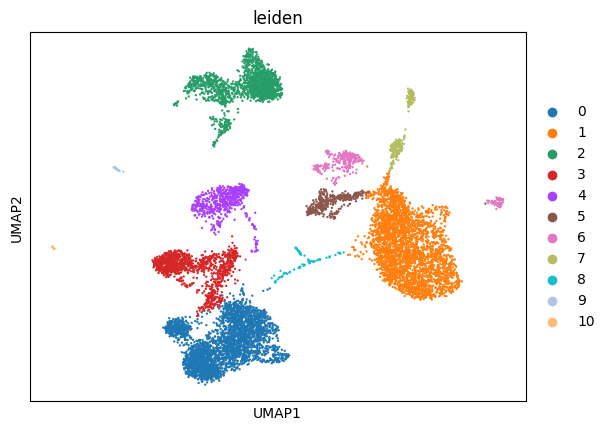

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

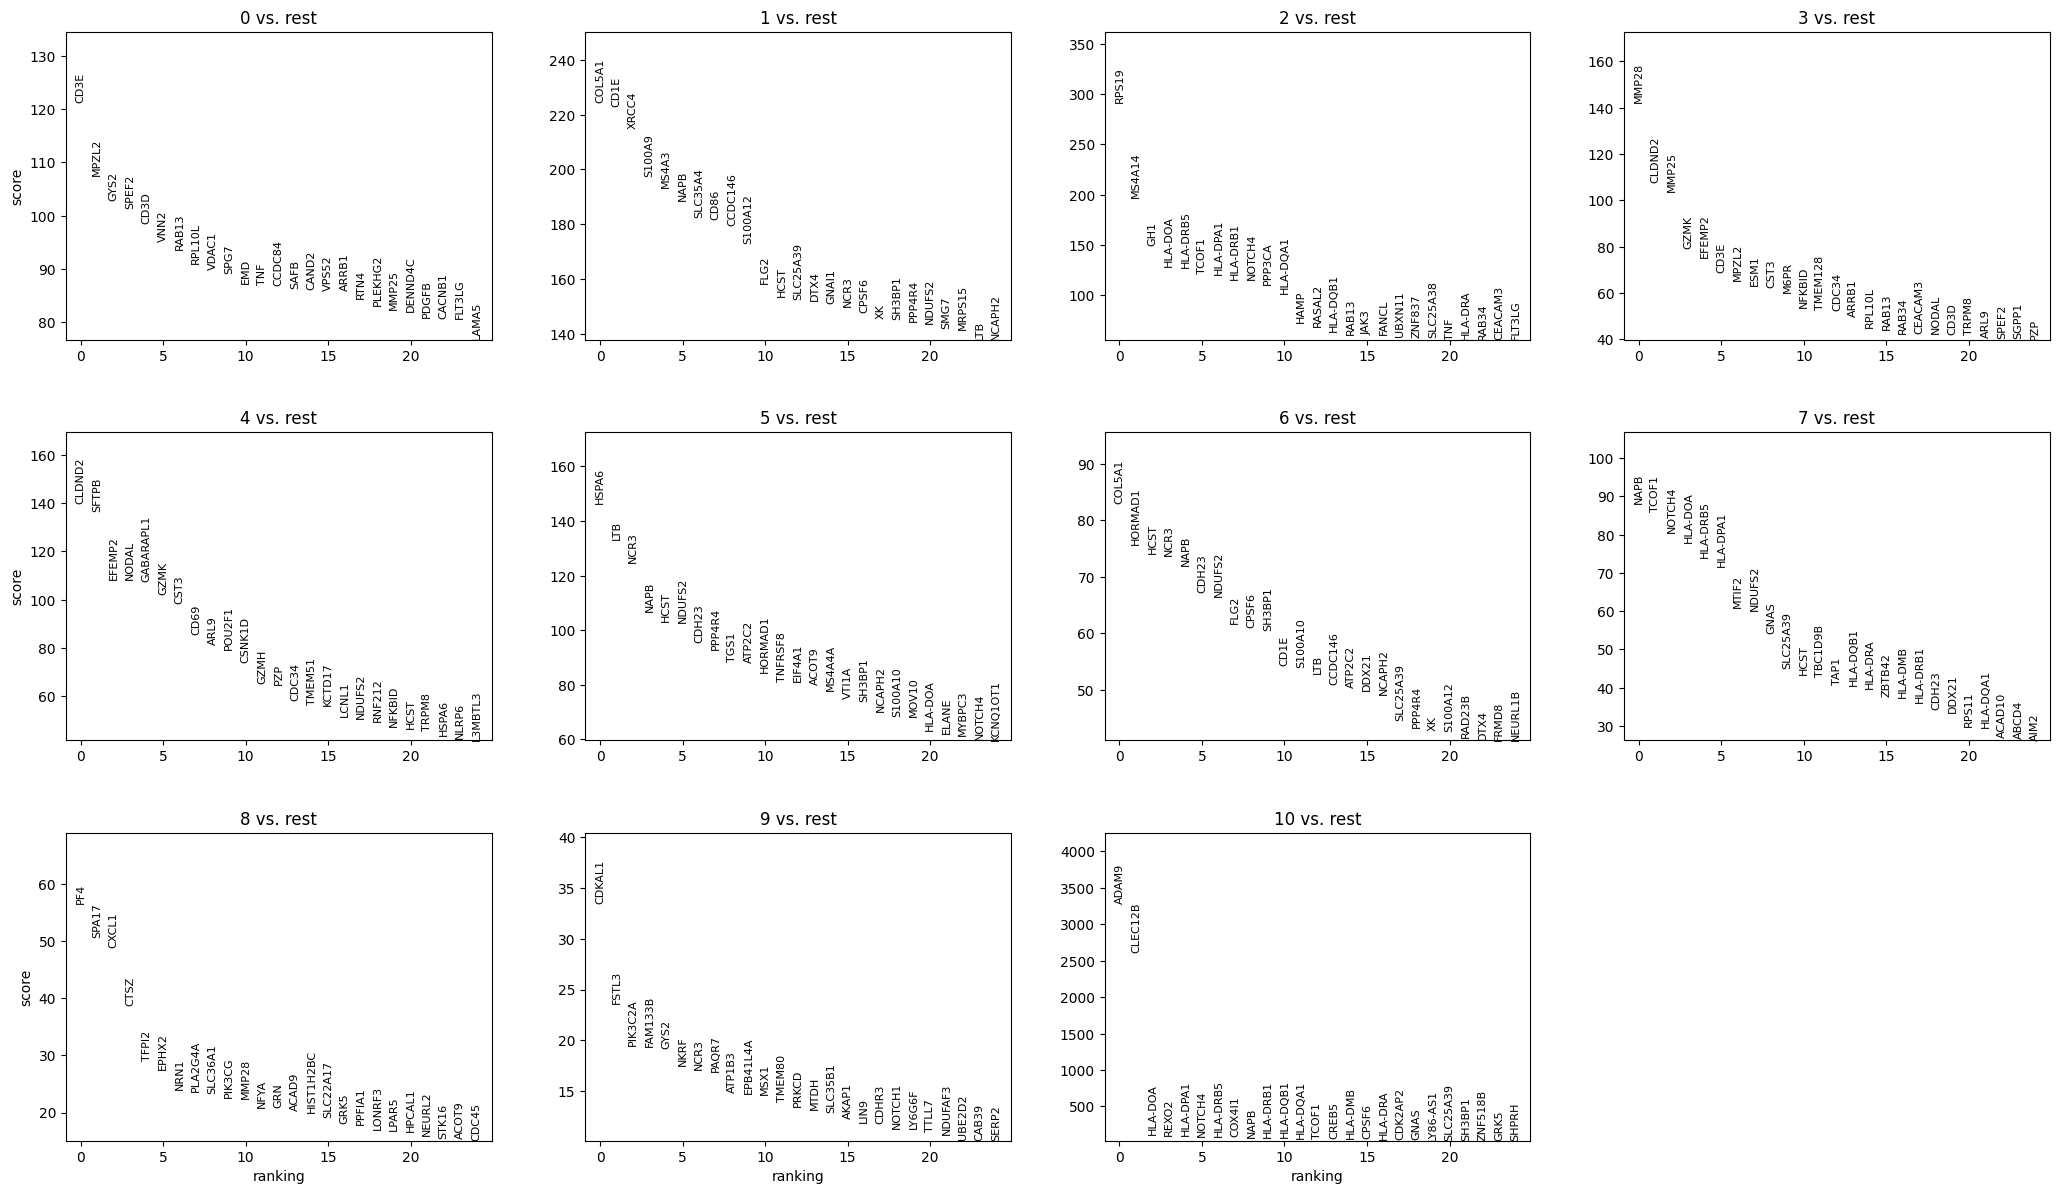

Submission file 'submission.csv' created successfully.


In [39]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import numpy as np

# Load the dataset
adata = sc.read('dataset.h5ad')

# Load gene names
gene_names = pd.read_csv('gene_names.csv', header=None).iloc[:, 0].values.tolist()
gene_names = [name for name in gene_names if name.strip()]  # Remove blank lines if present
if len(gene_names) != adata.n_vars:
    print("Warning: Number of gene names does not match number of variables in AnnData.")
    print("Adjusting gene names list to match.")
    gene_names = gene_names[:adata.n_vars]
adata.var_names = gene_names

# Quality control and normalization
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection
# Option 1: Highly Variable Genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)

# Scaling the data
sc.pp.scale(adata, max_value=10)

# Dimensionality reduction
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# Determine optimal resolution by evaluating silhouette scores
# Note: Silhouette score requires true labels for supervised evaluation,
# but here we use it internally to evaluate cluster separation.
# Alternatively, use other internal metrics or biological validation.

# Define a range of resolution values to test
resolution_values = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0]

best_resolution = 0.5
best_score = -1

for res in resolution_values:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_res_{res}')
    labels = adata.obs[f'leiden_res_{res}'].astype(int)
    # Calculate silhouette score based on PCA components
    score = silhouette_score(adata.obsm['X_pca'][:, :50], labels)
    print(f'Resolution: {res}, Silhouette Score: {score}')
    if score > best_score:
        best_score = score
        best_resolution = res

print(f'Best resolution selected: {best_resolution} with Silhouette Score: {best_score}')

# Perform Leiden clustering with the best resolution
sc.tl.leiden(adata, resolution= best_resolution, key_added='leiden')

# Optional: Further dimensionality reduction for visualization (e.g., UMAP)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', save='_leiden_clusters.png')

# Differential expression to identify marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save='_marker_genes.png')

# Annotate clusters based on marker genes
# Example annotation (this needs to be tailored based on actual marker gene expression)
# You can manually inspect the marker genes and assign cell type labels
# For simplicity, we skip this step here

# Prepare submission
# Ensure labels start from 1 as per the required format
adata.obs['leiden_label'] = adata.obs['leiden'].astype(int) + 1

submission_df = pd.DataFrame({
    'Id': adata.obs.index.astype(int),  # Ensure 'Id' is integer
    'Label': adata.obs['leiden_label']
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
